## PART 1: Study and Preprocessing 


In [1]:
import cv2
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import  OneHotEncoder
from collections import Counter
from sklearn.metrics import classification_report

We're using the Google Colab for the project, so we need to upload the CSV files in Google Drive and read the train and test files form there:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we have the train and test data and labels, so we can go to next section.

In [3]:
data1 = open('drive/My Drive/TestImgs.csv', 'rb')
labels1 = open('drive/My Drive/TestLabels.csv', 'rb')
data2 = open('drive/My Drive/TrainImgs.csv', 'rb')
labels2 = open('drive/My Drive/TrainLabels.csv', 'rb')

test_data = pd.read_csv(data1 , header=None)
test_lbs = pd.read_csv(labels1 , header=None)
train_data = pd.read_csv(data2, header=None)
train_lbs = pd.read_csv(labels2, header=None)

In this part, we show the images of each class in **train labels** set and also we show the **range of pixels** in the pictures:

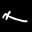

pixel range: [ 0 : 255 ]
Class:  1


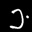

pixel range: [ 0 : 255 ]
Class:  2


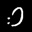

pixel range: [ 0 : 255 ]
Class:  3


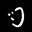

pixel range: [ 0 : 255 ]
Class:  4


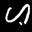

pixel range: [ 0 : 255 ]
Class:  5


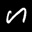

pixel range: [ 0 : 255 ]
Class:  6


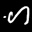

pixel range: [ 0 : 255 ]
Class:  7


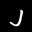

pixel range: [ 0 : 255 ]
Class:  8


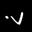

pixel range: [ 0 : 255 ]
Class:  9


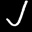

pixel range: [ 0 : 255 ]
Class:  10


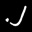

pixel range: [ 0 : 255 ]
Class:  11


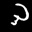

pixel range: [ 0 : 255 ]
Class:  12


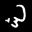

pixel range: [ 0 : 255 ]
Class:  13


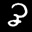

pixel range: [ 0 : 255 ]
Class:  14


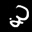

pixel range: [ 0 : 255 ]
Class:  15


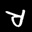

pixel range: [ 0 : 255 ]
Class:  16


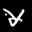

pixel range: [ 0 : 255 ]
Class:  17


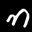

pixel range: [ 0 : 255 ]
Class:  18


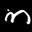

pixel range: [ 0 : 255 ]
Class:  19


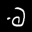

pixel range: [ 0 : 255 ]
Class:  20


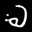

pixel range: [ 0 : 255 ]
Class:  21


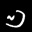

pixel range: [ 0 : 255 ]
Class:  22


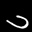

pixel range: [ 0 : 255 ]
Class:  23


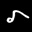

pixel range: [ 0 : 255 ]
Class:  24


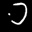

pixel range: [ 0 : 255 ]
Class:  25


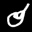

pixel range: [ 0 : 255 ]
Class:  26


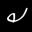

pixel range: [ 0 : 255 ]
Class:  27


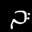

pixel range: [ 0 : 255 ]
Class:  28


In [4]:
for index, row in train_lbs.drop_duplicates(0).sort_values(by=0).iterrows():
    p = train_data.iloc[index, :].to_numpy().reshape(32,32)
    _, ret = cv2.imencode('.jpg', p) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    print("pixel range: [",ret.min(),':',ret.max(),']')
    print("Class: ",  row[0])

We need to check how much data we have in our train and test data sets:

In [5]:
len(train_lbs[0].unique()) , train_lbs[0].size

(28, 13440)

In [6]:
len(test_lbs[0].unique()) , test_lbs[0].size

(28, 3360)

In this part, we just want to use the data that its class is lower than 17, so we should remove (17,28) classes from our train and test data sets:

In [7]:
train_data = train_data[train_lbs[0] <= 16]
train_lbs = train_lbs[train_lbs[0]<= 16]
test_data = test_data[test_lbs[0] <= 16]
test_lbs = test_lbs[test_lbs[0] <= 16]
train_lbs

,0
0,1
1,1
2,1
3,1
4,1
...,...
13339,16
13340,16
13341,16
13342,16


In this part, we plot the amount of data in each class for the train and test data sets:

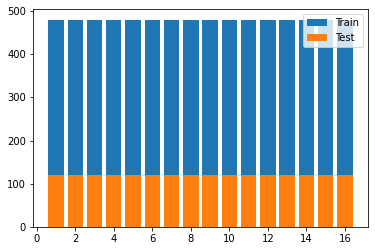

In [8]:
plt.bar(*zip(*Counter(train_lbs[0]).items()), label='Train')
plt.bar(*zip(*Counter(test_lbs[0]).items()), label='Test')
plt.legend()
plt.show()

As we can see in plot above, the number of rows in each class is nearly equal for train and test data sets.

Now that we have the range of pixels for pictures, we can normailize our data sets. we should scale the pixels range between 0 to 1 in order to make the neural network faster. Because large integer values will slow the learning process. All we have to do, is to divide the train and test data to **max pixel range (255)**: 

In [9]:
train_data = train_data / 255
test_data = test_data / 255

## PART 2: Completing the Given Code

### Data Loader

In [10]:
class Dataloader:
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors = pd.DataFrame(OneHotEncoder().fit_transform(labels).toarray())
        return onehot_vectors
    
    def __shuffle_dataset(self):
        randomize = np.random.permutation((self.__data.shape[0]))
        self.__data = self.__data[randomize]
        self.__onehot_labels = self.__onehot_labels[randomize]
    
    def __iter__(self):
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

### Activition Function

In [29]:
class Identical:

    def __init__(self):
        pass

    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Relu:

    def __init__(self): 
        pass
        
    def __val(self, matrix):
        relu_value = np.maximum(0, matrix)
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.matrix(np.full(np.shape(matrix), np.where(matrix >= 0, 1, 0)))
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:
  
    def __init__(self, negative_slope=0.01):
        self.negative_slope = negative_slope
    
    def __val(self, matrix):
        leaky_relu_value = np.where(matrix < 0, matrix * self.negative_slope, matrix)
        return leaky_relu_value

    def derivative(self, matrix):
        leaky_relu_derivative = np.matrix(np.full(np.shape(matrix), np.where(matrix >= 0, 1, self.negative_slope)))
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:

    def __init__(self): 
        pass

    def __val(self, matrix):
        sigmoid_value = 1/(1 + np.exp(-matrix))
        return sigmoid_value

    def derivative(self, matrix):
        matrix = self.__val(matrix)
        sigmoid_derivative = np.multiply(matrix, (1 - matrix))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:

    def __init__(self): 
        pass
        

    def __val(self, matrix):
        softmax_value = np.apply_along_axis(lambda row: np.exp(row - np.max(row))/np.sum(np.exp(row - np.max(row))), 1, matrix)
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:

    def __init__(self): 
        pass

    def __val(self, matrix):
        tanh_value = np.tanh(matrix)
        tanh_value = np.matrix(tanh_value)
        return tanh_value

    def derivative(self, matrix):
        tanh_derivative = 1 - np.power(self.__val(matrix), 2)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

### Loss Function

In [34]:
class CrossEntropy:

    def __init__(self): 
        pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)

        output = np.log(Softmax()(true_val))
        cross_entropy_value =  -1 * np.sum(np.multiply(expected_val, output), axis=1)
        
        return cross_entropy_value
    
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
                                           
        output = Softmax()(true_val)
        cross_entropy_derivative = output - expected_val
                                           
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

### Layer

In [45]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.

    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
      
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 
                                          'normal':self.__normal_weight, 
                                          'zero':self.__zero_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        
        self.__last_input = layer_input
        self.__last_activation_input = np.add(np.dot(self.__last_input, self.__weight), self.__bias)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
                
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        ones = np.matrix(np.ones((np.size(backprop_tensor,axis=0), 1)))
        dy = np.multiply(backprop_tensor, self.__last_activation_derivative)
        db = np.matmul(ones.T, dy)
        dw = np.matmul(self.__last_input.T, dy)
        backprop_tensor = np.matmul(dy, np.transpose(self.__weight))
        self.__weight -= lr * dw
        self.__bias -= lr * db
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        
        weights = np.matrix(np.random.uniform(low, high, size=(dim1, dim2)))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.matrix(np.random.normal(mean, np.sqrt(var), size=(dim1, dim2)))
        return weights
    
    def __zero_weight(self, dim1, dim2, **initializing_parameters):
        weights = np.matrix(np.zeros(shape=(dim1,dim2)))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

### Feed Forward Neural Network

In [46]:
class FeedForwardNN:
    def __init__(self, input_shape):

        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):

        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):

        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):

        assert type(self.__output_shape) != None, "Model is not compiled!"

        network_output = network_input
        for layer in self.__layers_list:
            network_output = layer.forward(network_output)
        
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):

        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    def __train(self, trainloader):

        batch_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):

        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)

        return np.mean(batch_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):

        network_output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(network_output, y_batch)
        batch_average_loss = np.mean(self.__loss(network_output, y_batch))

        self.__update_weights(network_output, y_batch)

        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):

        network_output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(network_output, y_batch)
        batch_average_loss = np.mean(self.__loss(network_output, y_batch))
        
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):

        labels = outputs.argmax(1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):

        labels = self.__get_labels(output)
        expected_labels = self.__get_labels(expected_output)
        accuracy = np.count_nonzero(labels == expected_labels) / np.size(output, axis=0) * 100
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        backpropagation_tensor = self.__loss.derivative(output, y_train)
        for layer in reversed(self.__layers_list):
            backpropagation_tensor = layer.update_weights(backpropagation_tensor, self.__lr)
        return

In [40]:
train_data = pd.DataFrame(data=train_data)
test_data = pd.DataFrame(data = test_data)
train_lbs = pd.DataFrame(data=train_lbs)
test_lbs = pd.DataFrame(data= test_lbs)

## PART 3: Data classification

These are the default parameters for the Neural Network:

In [41]:
INPUT_SHAPE = 32*32
LEARNING_RATE = 0.005
EPOCHS = 100
BATCH_SIZE = 32

Now we must make a training model of the Neural Network with given parameters. in order to do that, we designed below function:

In [47]:
def train_model(activation=Relu(), initial='uniform', print_results=True, lr=LEARNING_RATE, epochs=EPOCHS, batch_size=BATCH_SIZE):
  
  TRAINLOADER = [batch for batch in Dataloader(train_data, train_lbs, n_classes=16, batch_size=batch_size, shuffle=False)]
  TESTLOADER = [batch for batch in Dataloader(test_data,test_lbs, n_classes=16, batch_size=batch_size, shuffle=False)]

  network = FeedForwardNN(INPUT_SHAPE)
  network.add_layer(100, activation=activation, initial_weight=initial)
  network.add_layer(16, activation=Identical(), initial_weight=initial)
  network.set_training_param(loss=CrossEntropy(), lr=lr)

  log = network.fit(epochs, TRAINLOADER, TESTLOADER, print_results=print_results)
  return log

### Neural Network with Default Parameters: 

In [48]:
log = train_model()

Epoch 1:
	Train: Average Accuracy: 8.90625	Average Loss: 3.131722452248539
	Test: Average Accuracy: 24.84375	Average Loss: 2.243751897924972
Epoch 2:
	Train: Average Accuracy: 27.682291666666668	Average Loss: 2.0122582554009636
	Test: Average Accuracy: 36.666666666666664	Average Loss: 1.7671239993691215
Epoch 3:
	Train: Average Accuracy: 39.21875	Average Loss: 1.6611874758461307
	Test: Average Accuracy: 41.979166666666664	Average Loss: 1.570822672795867
Epoch 4:
	Train: Average Accuracy: 46.002604166666664	Average Loss: 1.4564970170879272
	Test: Average Accuracy: 47.291666666666664	Average Loss: 1.435901755980608
Epoch 5:
	Train: Average Accuracy: 50.169270833333336	Average Loss: 1.3178923450487106
	Test: Average Accuracy: 51.510416666666664	Average Loss: 1.3394743738287596
Epoch 6:
	Train: Average Accuracy: 54.244791666666664	Average Loss: 1.215451508793387
	Test: Average Accuracy: 53.125	Average Loss: 1.2792377586804087
Epoch 7:
	Train: Average Accuracy: 57.239583333333336	Average Lo

### Neural Network with Initial weighted = Zero :

In [49]:
log = train_model(activation=Relu(), initial='zero')

Epoch 1:
	Train: Average Accuracy: 0.10416666666666667	Average Loss: 2.7876409495383507
	Test: Average Accuracy: 6.25	Average Loss: 2.772641038603346
Epoch 2:
	Train: Average Accuracy: 0.0	Average Loss: 2.787671756348796
	Test: Average Accuracy: 6.25	Average Loss: 2.772650839289024
Epoch 3:
	Train: Average Accuracy: 0.0	Average Loss: 2.787675579363552
	Test: Average Accuracy: 6.25	Average Loss: 2.7726517588872666
Epoch 4:
	Train: Average Accuracy: 0.0	Average Loss: 2.7876759305838474
	Test: Average Accuracy: 6.25	Average Loss: 2.7726518416486803
Epoch 5:
	Train: Average Accuracy: 0.0	Average Loss: 2.7876759621352267
	Test: Average Accuracy: 6.25	Average Loss: 2.772651849069935
Epoch 6:
	Train: Average Accuracy: 0.0	Average Loss: 2.7876759649639933
	Test: Average Accuracy: 6.25	Average Loss: 2.772651849735185
Epoch 7:
	Train: Average Accuracy: 0.0	Average Loss: 2.787675965217564
	Test: Average Accuracy: 6.25	Average Loss: 2.772651849794817
Epoch 8:
	Train: Average Accuracy: 0.0	Average 

As you can see, if we set all weights to zero, the the derivatives won't change. Because of that, the accuracy will stay the same in each epoch.
Bacause in calculating gradient decent in every layer, we use the weight and gradient obtained by backpropagation from the next layer. So if the weights are zero, in multiplying, the result become zero. As a Result, the weights won't change, so every epoch won't improve the accuracy.

### Neural Network with Learning Rate = 0.0005

In [ ]:
log = train_model(activation=Relu(), initial='uniform', print_results=True, lr=0.05)

Epoch 1:
	Train: Average Accuracy: 0.0	Average Loss: 3.93323663281484
	Test: Average Accuracy: 6.25	Average Loss: 2.7794906687922794
Epoch 2:
	Train: Average Accuracy: 0.0	Average Loss: 2.931023445724689
	Test: Average Accuracy: 6.25	Average Loss: 2.779490668792043
Epoch 3:
	Train: Average Accuracy: 0.0	Average Loss: 2.931023445724677
	Test: Average Accuracy: 6.25	Average Loss: 2.779490668792043
Epoch 4:
	Train: Average Accuracy: 0.0	Average Loss: 2.931023445724677
	Test: Average Accuracy: 6.25	Average Loss: 2.779490668792043
Epoch 5:
	Train: Average Accuracy: 0.0	Average Loss: 2.931023445724677
	Test: Average Accuracy: 6.25	Average Loss: 2.779490668792043
Epoch 6:
	Train: Average Accuracy: 0.0	Average Loss: 2.931023445724677
	Test: Average Accuracy: 6.25	Average Loss: 2.779490668792043
Epoch 7:
	Train: Average Accuracy: 0.0	Average Loss: 2.931023445724677
	Test: Average Accuracy: 6.25	Average Loss: 2.779490668792043
Epoch 8:
	Train: Average Accuracy: 0.0	Average Loss: 2.93102344572467

As you can see, the learning rate is too large and as a result, the learning accuracy will decrease in both train and test sets. Because in large learning rates, our model may diverge and never find the optimal weight and biases.

In [ ]:
log = train_model(activation=Relu(), initial='uniform', print_results=True, lr=LEARNING_RATE * 0.1)

Epoch 1:
	Train: Average Accuracy: 1.015625	Average Loss: 3.0065570802311483
	Test: Average Accuracy: 6.25	Average Loss: 2.7363670989509887
Epoch 2:
	Train: Average Accuracy: 3.8802083333333335	Average Loss: 2.8640765005170534
	Test: Average Accuracy: 9.166666666666666	Average Loss: 2.569346479979608
Epoch 3:
	Train: Average Accuracy: 10.481770833333334	Average Loss: 2.620262348276176
	Test: Average Accuracy: 19.010416666666668	Average Loss: 2.3619942332036232
Epoch 4:
	Train: Average Accuracy: 17.252604166666668	Average Loss: 2.4070929372283016
	Test: Average Accuracy: 27.395833333333332	Average Loss: 2.2008447628771446
Epoch 5:
	Train: Average Accuracy: 25.1953125	Average Loss: 2.2357616977533166
	Test: Average Accuracy: 31.458333333333332	Average Loss: 2.0640905320378105
Epoch 6:
	Train: Average Accuracy: 30.8203125	Average Loss: 2.0968057663732904
	Test: Average Accuracy: 35.104166666666664	Average Loss: 1.960245660557431
Epoch 7:
	Train: Average Accuracy: 35.299479166666664	Averag

As you can see, the learning is too small and as a result, the learning improvment is so slow and the learning needs more epoches to get better accuracy.


### Finding Best Learning Rate:

In [ ]:
for lr in range(5):
  log = train_model(activation=Relu(), initial='uniform', print_results=False, lr= 0.005 + (lr * 0.005))
  print('For Learning Rate', 0.005 + (lr * 0.005) ,':')
  print("Train Accuracy:",log['train_accuracy'][-1])
  print("Test Accuracy",log['test_accuracy'][-1],'\n')

For Learning Rate 0.005  :
Train Accuracy: 100.0
Test Accuracy 72.76041666666667 

For Learning Rate 0.01  :
Train Accuracy: 99.97395833333333
Test Accuracy 68.33333333333333 

For Learning Rate 0.015  :
Train Accuracy: 99.89583333333333
Test Accuracy 66.30208333333333 

For Learning Rate 0.02  :
Train Accuracy: 83.1640625
Test Accuracy 59.322916666666664 

For Learning Rate 0.025  :
Train Accuracy: 38.9453125
Test Accuracy 40.520833333333336 



As you can see, The default learning rate is the best learning rate.

### Finding Best Activation Function

In [ ]:
activation_list = [Sigmoid(),Tanh(),LeakyRelu()]

for activation in range(3):
  log = train_model(activation= activation_list[activation], initial='uniform', print_results=False, lr=LEARNING_RATE)
  print('For Activation Function', activation_list[activation],':')
  print("Train Accuracy:",log['train_accuracy'][-1])
  print("Test Accuracy",log['test_accuracy'][-1],'\n')

For Activation Function <__main__.Sigmoid object at 0x7fcacd3a4df0> :
Train Accuracy: 97.86458333333333
Test Accuracy 77.8125 

For Activation Function <__main__.Tanh object at 0x7fcacd3a4d60> :
Train Accuracy: 100.0
Test Accuracy 76.71875 

For Activation Function <__main__.LeakyRelu object at 0x7fcacd310940> :
Train Accuracy: 99.97395833333333
Test Accuracy 72.1875 



**sigmoid**: The sigmoid function normalizes the values(all of them are between 0 and 1).<br>

**Hyperbolic Tangent**: Hyperbolic Tangent function normalizes the values in between -1 and 1 thus it's a zero centered function.<br>

**Leaky Relu**:This function returns x if it receives any positive input, but for any negative value of x, it returns a really small value which is 0.01 times x. Thus it gives an output for negative values as well.<br>

####  Comparing Activation Functions:
**sigmoid**: when x(exp power) is a large positive or negative value, it'll decrease to 0. Also, it's more computationally expensive than other functions.

**Hyperbolic Tangent**: Unfortunately, zero-centered activation functions saturate at their asymptotes, leading to a weak training signal. ReLU avoids this problem but it is not zero-centered.

The problem with Sigmoid and Tanhs' performance is that they saturate. A neuron is said to be saturated when extremely large weights cause the neuron to produce values (gradients) that are very close to the range boundary.

if the gradient is constantly 1, it most likely means that the neuron is over-fitting on training data and will likely perform poorly on test data.

**Leaky Relu**: Leaky Relu is faster both in convergence and its computation. This function doesn't saturate and the gradients don't get killed. But the problem is that it's not consistent. Leaky Relu has a slope for negative values while Relu deletes these values.

### Result of Neural Network with Different Batch Sizes(15 , 256):

In [ ]:
sizes = [16, 256]

for size in range(2):
  log = train_model(activation=LeakyRelu(), initial='uniform', print_results=False,lr=LEARNING_RATE, epochs=EPOCHS, batch_size=sizes[size])
  print('For Batch Size', sizes[size],':')
  print("Train Accuracy:",log['train_accuracy'][-1])
  print("Test Accuracy",log['test_accuracy'][-1],'\n')

For Batch Size 16 :
Train Accuracy: 100.0
Test Accuracy 77.55208333333333 

For Batch Size 256 :
Train Accuracy: 90.98958333333333
Test Accuracy 61.1328125 




The batch size = 256 has lower accuracy. because with the larger batch size our model has poor generalization and over-fits and doesn't converge.

#### Advantages of very small batch size
It takes less memory. Also, it is more generalized and has better accuracy overall.

#### Disadvantages of very small batch size
The model is not guaranteed to converge to the global optima. It will bounce around the global optima. Therefore, under no computational constraints, 

#### Best Approach
it is often advised that one starts at a small batch size, reaping the benefits of faster training dynamics, and steadily grows the batch size through training, also reaping the benefits of guaranteed convergence.

## PART 4: Using Tensorflow and Keras Libararies

In this part, first we need to get the **cifar10 database** using **tensorflow** library:

In [ ]:
import tensorflow as tf
import seaborn as sns
import gc

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
del cifar10
gc.collect()

1274

This is a distribution plot of cifar10 database in each class. in every class there are 6000 pictures: 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[Text(0, 0, 'airplane'),
  Text(0, 0, 'automobile'),
  Text(0, 0, 'bird'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'deer'),
  Text(0, 0, 'dog'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'ship'),
  Text(0, 0, 'truck')]]

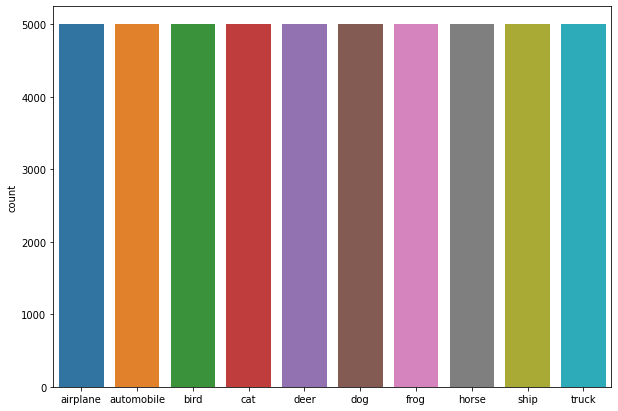

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

### Normalizing Data Sets

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

### OneHot Coding Using to_categorical Function

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

### Result and Plotting Function
in later parts, we need to train Nueral Network with tenserflow library, so we need to report its results and plot the outcome:

In [ ]:
def result(model, x_train, y_train, x_test, y_test):
  y_pred = model.predict(x_train)
  y_pred = np.argmax(y_pred, axis=1)
  print("Train:")
  print(classification_report(y_train, y_pred))

  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis=1)
  print("Test:")
  print(classification_report(y_test, y_pred))

def plot(nn_result):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  plt.tight_layout()

  ax1.set_title("Accuracy")
  ax1.set_xlabel("Epoch")
  ax1.plot(nn_result.history['accuracy'], label="train")
  ax1.plot(nn_result.history['val_accuracy'], label="test")
  ax1.legend()

  ax2.set_title("Loss")
  ax2.set_xlabel("Epoch")
  ax2.plot(nn_result.history['loss'], label="train")
  ax2.plot(nn_result.history['val_loss'], label="test")
  ax2.legend()
  plt.show()

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (32,32,3)))
model.add(tf.keras.layers.Dense(100, activation='relu',input_shape = (32*32*3,)))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.9048 - accuracy: 0.3168 - val_loss: 1.8110 - val_accuracy: 0.3370
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7201 - accuracy: 0.3910 - val_loss: 1.7919 - val_accuracy: 0.3722
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6384 - accuracy: 0.4213 - val_loss: 1.5860 - val_accuracy: 0.4403
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5875 - accuracy: 0.4389 - val_loss: 1.5790 - val_accuracy: 0.4353
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5450 - accuracy: 0.4538 - val_loss: 1.5378 - val_accuracy: 0.4506
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5107 - accuracy: 0.4687 - val_loss: 1.5398 - val_accuracy: 0.4545
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4836 - accuracy: 0.4767 - val_loss: 1.4717 - val_accuracy:

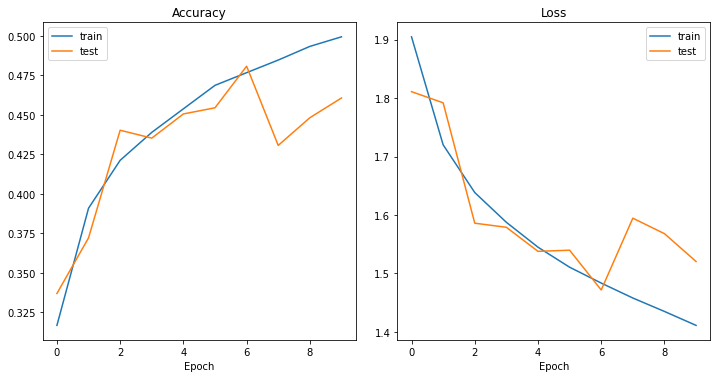

In [ ]:
nn_result = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)

In [ ]:
del model
del nn_result
gc.collect()

9528

### Optimizer

**Momentum**: Momentum is an extension to the gradient descent optimization algorithm, often referred to as gradient descent with momentum.

#### Advantages

It is designed to accelerate the optimization process, e.g. decrease the number of function evaluations required to reach the optima, or to improve the capability of the optimization algorithm, e.g. result in a better final result.

Momentum involves adding an additional hyperparameter that controls the amount of history (momentum) to include in the update equation, i.e. the step to a new point in the search space. The value for the hyperparameter is defined in the range 0.0 to 1.0 and often has a value close to 1.0, such as 0.8, 0.9, or 0.99. A momentum of 0.0 is the same as gradient descent without momentum.

Momentum is most useful in optimization problems where the objective function has a large amount of curvature (e.g. changes a lot), meaning that the gradient may change a lot over relatively small regions of the search space.

In [ ]:
def create_model(moment):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = (32,32,3)))
    model.add(tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.01),input_shape = (32*32*3,)))
    model.add(tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
    model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5), loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])
    return model

#### Momentum = 0.5

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8671 - accuracy: 0.3291 - val_loss: 1.7258 - val_accuracy: 0.3753
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.6813 - accuracy: 0.4018 - val_loss: 1.7651 - val_accuracy: 0.3669
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6042 - accuracy: 0.4301 - val_loss: 1.6358 - val_accuracy: 0.4150
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5494 - accuracy: 0.4509 - val_loss: 1.6447 - val_accuracy: 0.4193
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5079 - accuracy: 0.4652 - val_loss: 1.5647 - val_accuracy: 0.4432
Epoch 6/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.4735 - accuracy: 0.4760 - val_loss: 1.5189 - val_accuracy: 0.4554
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4431 - accuracy: 0.4879 - val_loss: 1.4915 - val_accurac

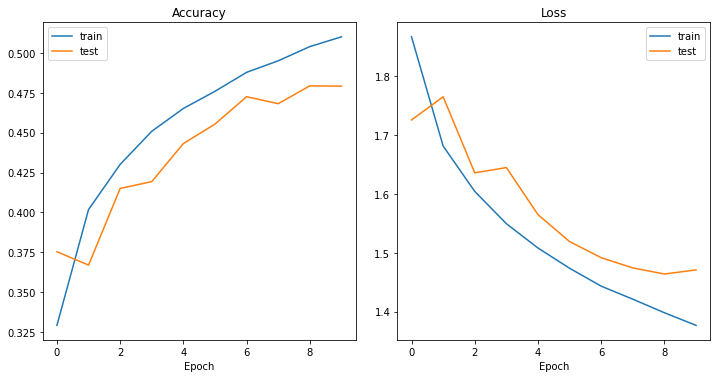

In [ ]:
model = create_model(0.5)
nn_result = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.8583 - accuracy: 0.3310 - val_loss: 1.6893 - val_accuracy: 0.4016
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6782 - accuracy: 0.4041 - val_loss: 1.6403 - val_accuracy: 0.4173
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6003 - accuracy: 0.4333 - val_loss: 1.5915 - val_accuracy: 0.4321
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5448 - accuracy: 0.4499 - val_loss: 1.5480 - val_accuracy: 0.4496
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5022 - accuracy: 0.4674 - val_loss: 1.5389 - val_accuracy: 0.4471
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4729 - accuracy: 0.4770 - val_loss: 1.5091 - val_accuracy: 0.4644
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4425 - accuracy: 0.4889 - val_loss: 1.4725 - val_accurac

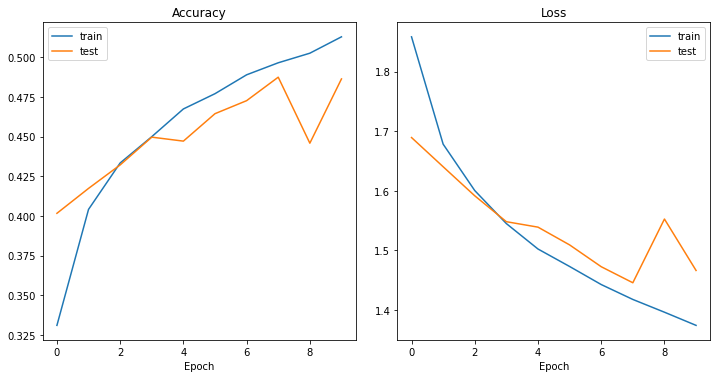

In [ ]:
model = create_model(0.9)
nn_result = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.8615 - accuracy: 0.3273 - val_loss: 1.8118 - val_accuracy: 0.3407
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6733 - accuracy: 0.4022 - val_loss: 1.6420 - val_accuracy: 0.4104
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5938 - accuracy: 0.4311 - val_loss: 1.6707 - val_accuracy: 0.4037
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5387 - accuracy: 0.4531 - val_loss: 1.5579 - val_accuracy: 0.4465
Epoch 5/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5004 - accuracy: 0.4654 - val_loss: 1.4892 - val_accuracy: 0.4777
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4677 - accuracy: 0.4747 - val_loss: 1.5099 - val_accuracy: 0.4608
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4395 - accuracy: 0.4868 - val_loss: 1.4974 - val_accuracy:

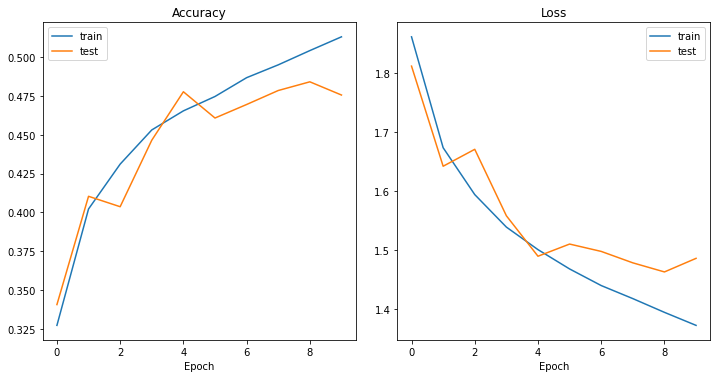

In [ ]:
model = create_model(0.98)
nn_result = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)

In [ ]:
del model
del history
gc.collect()

47288

### Comparing Momentums Results
As we can in results, the accuracy for f1-score rises from momentum  0.5 to 0.9 .But accuracy for f1-score falls from momentum 0.9 to 0.98.Because too much of momentum may create issues as well as systems that are not stable may create oscillations that grow in magnitude, in such cases one needs to add decay terms and so on. It's just physics applied to neural net training or numerical optimizations.

### Adam
**Adam**: an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters.

In [ ]:
def adam():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (32,32,3)))
  model.add(tf.keras.layers.Dense(100, activation='relu',input_shape = (32*32*3,)))
  model.add(tf.keras.layers.Dense(100, 'relu'))
  model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])
  return model

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8607 - accuracy: 0.3252 - val_loss: 1.6815 - val_accuracy: 0.3902
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6892 - accuracy: 0.3923 - val_loss: 1.6640 - val_accuracy: 0.4121
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6185 - accuracy: 0.4196 - val_loss: 1.6174 - val_accuracy: 0.4234
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5788 - accuracy: 0.4356 - val_loss: 1.5744 - val_accuracy: 0.4392
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5516 - accuracy: 0.4441 - val_loss: 1.5571 - val_accuracy: 0.4413
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5281 - accuracy: 0.4531 - val_loss: 1.5416 - val_accuracy: 0.4596
Epoch 7/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.5106 - accuracy: 0.4608 - val_loss: 1.5073 - val_accu

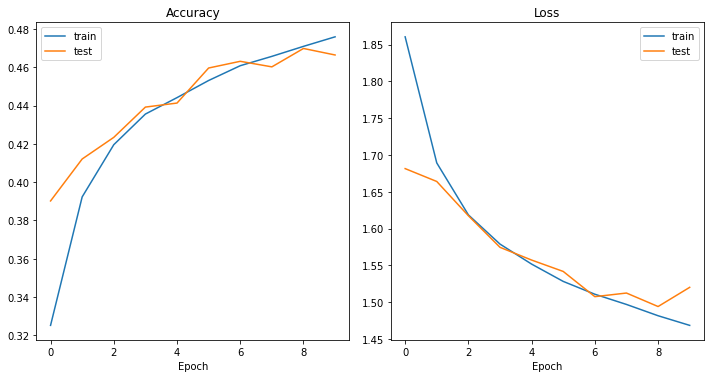

In [ ]:
model = adam()
history = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(history)

As we can see, the Adam accuracy and generalization is worse than SGD approach. On image classification problems, its generalization performance is significantly worse than stochastic gradient descent (SGD).We can tune some of Adam parameters to make better generalization, but this approach makes Adam omputationally expensive.

In [ ]:
del model
del history
gc.collect()

36261

### Epoches
In neural network, if the number of epoches are too low, the neural network training will be uncompleted and it lead to underfitting. If the number of epoches are too high, the neural netwrok training will be biased and the generalization and accuracy results in train set will be high, but in test, the genrelazation and accuracy results will be low and it means the overfitting occurred in our neural network.

there are several approaches to fix overfitting:
- Early stopping is a form of regularization while training a model with an iterative method, such as gradient descent.
-  decrease the complexity of the model. To decrease the complexity, we can simply remove layers or reduce the number of neurons to make the network smaller. 
-In the case of neural networks, data augmentation simply means increasing size of the data that is increasing the number of images present in the dataset.
-Regularization is a technique to reduce the complexity of the model. It does so by adding a penalty term to the loss function. The most common techniques are known as L1 and L2 regularization.
-Dropout is a regularization technique that prevents neural networks from overfitting. Regularization methods like L1 and L2 reduce overfitting by modifying the cost function. Dropout on the other hand, modify the network itself.

Epoch 1/20
1563/1563 [==============================] - 12s 7ms/step - loss: 1.8798 - accuracy: 0.3183 - val_loss: 1.7332 - val_accuracy: 0.3878
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7010 - accuracy: 0.3880 - val_loss: 1.6474 - val_accuracy: 0.4043
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6398 - accuracy: 0.4095 - val_loss: 1.6251 - val_accuracy: 0.4112
Epoch 4/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6034 - accuracy: 0.4232 - val_loss: 1.6065 - val_accuracy: 0.4251
Epoch 5/20
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5737 - accuracy: 0.4343 - val_loss: 1.6305 - val_accuracy: 0.4218
Epoch 6/20
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5514 - accuracy: 0.4449 - val_loss: 1.5733 - val_accuracy: 0.4341
Epoch 7/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.5339 - accuracy: 0.4495 - val_loss: 1.5314 - val_a

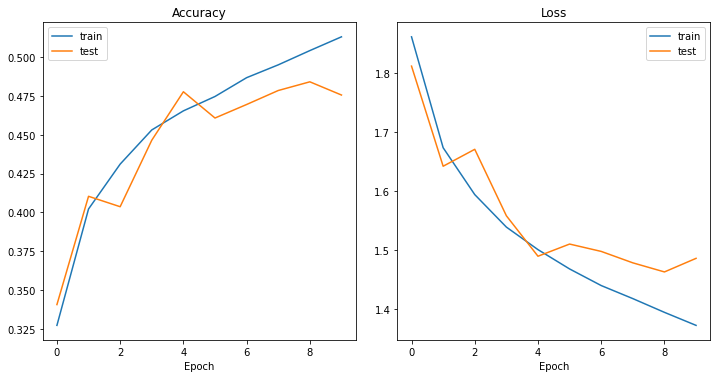

In [ ]:
model = adam()
history = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=20, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)

As we can see, the accuracy of f1-score in train set is higher than the accuracy of f1-score in test set and it can be the sign of overfitting.

### Loss

As a rule of thumb, mean squared error (MSE) is more appropriate for regression problems, that is, problems where the output is a numerical value (i.e. a floating-point number or, in general, a real number). However, in principle, you can use the MSE for classification problems too (even though that may not be a good idea). MSE can be preceded by the sigmoid function, which outputs a number p∈[0,1]
, which can be interpreted as the probability of the input belonging to one of the classes, so the probability of the input belonging to the other class is 1−p
.

Similarly, cross-entropy (CE) is mainly used for classification problems, that is, problems where the output can belong to one of a discrete set of classes. The CE loss function is usually separately implemented for binary and multi-class classification problems.

In [ ]:
def loss(loss_kind):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (32,32,3)))
  model.add(tf.keras.layers.Dense(100, activation='relu',input_shape = (32*32*3,)))
  model.add(tf.keras.layers.Dense(100, 'relu'))
  model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss_kind, metrics=["accuracy"])
  return model

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0801 - accuracy: 0.3102 - val_loss: 0.0767 - val_accuracy: 0.3576
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0764 - accuracy: 0.3589 - val_loss: 0.0754 - val_accuracy: 0.3710
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0752 - accuracy: 0.3707 - val_loss: 0.0740 - val_accuracy: 0.3878
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0745 - accuracy: 0.3797 - val_loss: 0.0733 - val_accuracy: 0.3939
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0739 - accuracy: 0.3893 - val_loss: 0.0735 - val_accuracy: 0.3908
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0734 - accuracy: 0.3950 - val_loss: 0.0741 - val_accuracy: 0.3880
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0734 - accuracy: 0.3938 - val_loss: 0.0733 - val_accu

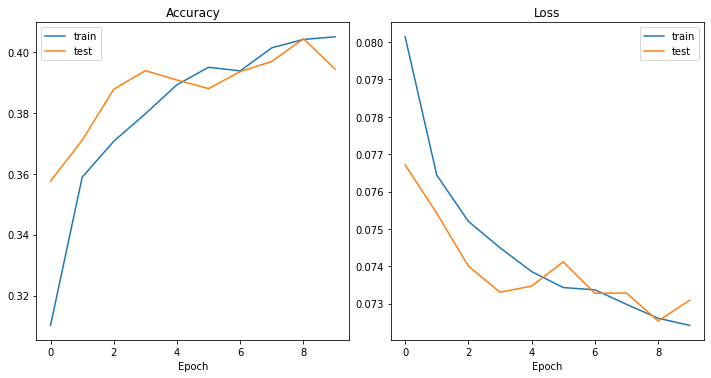

In [ ]:
model = loss('mse')
nn_result = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8713 - accuracy: 0.3235 - val_loss: 1.7154 - val_accuracy: 0.3797
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.7040 - accuracy: 0.3875 - val_loss: 1.6205 - val_accuracy: 0.4244
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.6334 - accuracy: 0.4156 - val_loss: 1.6526 - val_accuracy: 0.4102
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5856 - accuracy: 0.4320 - val_loss: 1.5948 - val_accuracy: 0.4307
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5532 - accuracy: 0.4458 - val_loss: 1.5599 - val_accuracy: 0.4421
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5256 - accuracy: 0.4560 - val_loss: 1.5375 - val_accuracy: 0.4519
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5034 - accuracy: 0.4624 - val_loss: 1.5010 - val_accu

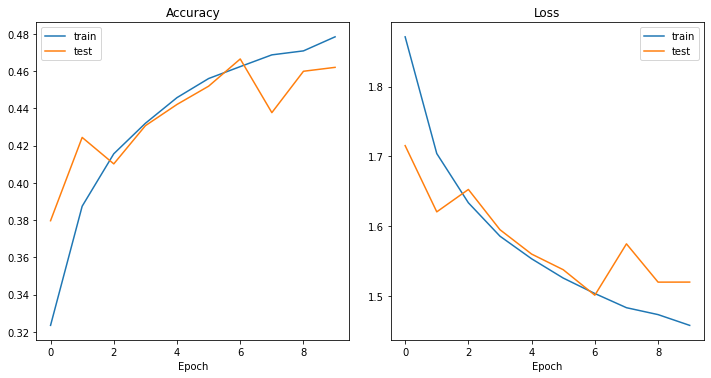

In [ ]:
model = loss(tf.keras.losses.CategoricalCrossentropy())
nn_result = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)

As you can see, the MSE accuracy and generalization are worse than the Categorical Cross entrop accuracy and generalization.

### DropOut
The term “dropout” refers to dropping out the nodes (input and hidden layer) in a neural network. All the forward and backwards connections with a dropped node are temporarily removed, thus creating a new network architecture out of the parent network.
### Effect on Network
In the overfitting problem, the model learns the statistical noise. To be precise, the main motive of training is to decrease the loss function, given all the units (neurons). So in overfitting, a unit may change in a way that fixes up the mistakes of the other units. This leads to complex co-adaptations, which in turn leads to the overfitting problem because this complex co-adaptation fails to generalise on the unseen dataset.

Now, if we use dropout, it prevents these units to fix up the mistake of other units, thus preventing co-adaptation, as in every iteration the presence of a unit is highly unreliable. So by randomly dropping a few units (nodes), it forces the layers to take more or less responsibility for the input by taking a probabilistic approach.

### Result
This ensures that the model is getting generalised and hence reducing the overfitting problem.

In [ ]:
def dropout():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (32,32,3)))
  model.add(tf.keras.layers.Dense(100, activation='relu',input_shape = (32*32*3,),))
  model.add(tf.keras.layers.Dropout(rate=0.1))
  model.add(tf.keras.layers.Dense(100, 'relu',))
  model.add(tf.keras.layers.Dropout(rate=0.1))
  model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax,))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])
  return model

Epoch 1/30
1563/1563 [==============================] - 10s 6ms/step - loss: 1.9776 - accuracy: 0.2674 - val_loss: 1.8147 - val_accuracy: 0.3365
Epoch 2/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.8556 - accuracy: 0.3203 - val_loss: 1.7889 - val_accuracy: 0.3513
Epoch 3/30
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8172 - accuracy: 0.3358 - val_loss: 1.7370 - val_accuracy: 0.3736
Epoch 4/30
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7911 - accuracy: 0.3463 - val_loss: 1.7076 - val_accuracy: 0.3835
Epoch 5/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7759 - accuracy: 0.3541 - val_loss: 1.7130 - val_accuracy: 0.3741
Epoch 6/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7694 - accuracy: 0.3575 - val_loss: 1.6806 - val_accuracy: 0.3925
Epoch 7/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7526 - accuracy: 0.3610 - val_loss: 1.6597 - val_accura

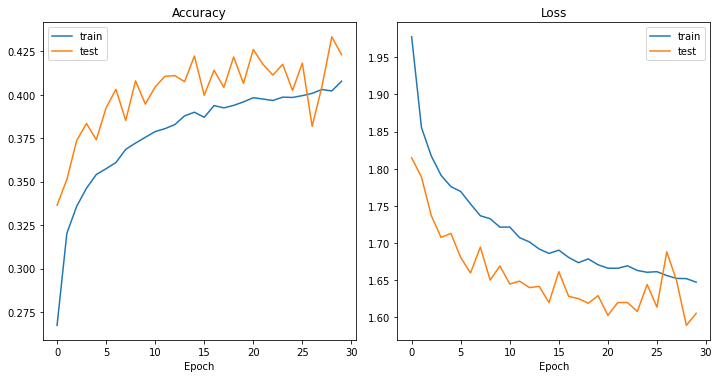

In [ ]:
model = dropout()
nn_result = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=30, batch_size=32)
result(model, x_train, y_train, x_test, y_test)
plot(nn_result)